# 1. Loading Data and Packages


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
df = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75473 entries, 0 to 75472
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                75473 non-null  object 
 1   town                 75473 non-null  object 
 2   flat_type            75473 non-null  object 
 3   block                75473 non-null  object 
 4   street_name          75473 non-null  object 
 5   storey_range         75473 non-null  object 
 6   floor_area_sqm       75473 non-null  float64
 7   flat_model           75473 non-null  object 
 8   lease_commence_date  75473 non-null  int64  
 9   remaining_lease      75473 non-null  object 
 10  resale_price         75473 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 6.3+ MB


In [3]:
df['month'] = pd.to_datetime(df['month'])
df['Year'] = df['month'].apply(lambda x: x.year)
df['Month'] = df['month'].apply(lambda x: x.month)

## Transform & combine attributes

In [4]:
df['remaining_lease'] = 99 - (2019 - df['lease_commence_date'])
df['house_age'] = df['Year'] - df['lease_commence_date']
df['flat_type_model'] = df['flat_type']+' '+df['flat_model']
df = df.drop(columns = ['flat_model','flat_type'])
df.head()
df = df[df['Year'] == 2019]
df = df.drop(columns = ['Year','month','block','street_name'])

In [5]:
df

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Month,house_age,flat_type_model
42070,ANG MO KIO,01 TO 03,68.0,1981,61,270000.0,1,38,3 ROOM New Generation
42071,ANG MO KIO,04 TO 06,73.0,1976,56,295000.0,1,43,3 ROOM New Generation
42072,ANG MO KIO,07 TO 09,67.0,1978,58,270000.0,1,41,3 ROOM New Generation
42073,ANG MO KIO,01 TO 03,67.0,1978,58,230000.0,1,41,3 ROOM New Generation
42074,ANG MO KIO,01 TO 03,68.0,1981,61,262500.0,1,38,3 ROOM New Generation
...,...,...,...,...,...,...,...,...,...
64251,YISHUN,04 TO 06,142.0,1988,68,580000.0,12,31,EXECUTIVE Apartment
64252,YISHUN,07 TO 09,146.0,1988,68,565000.0,12,31,EXECUTIVE Maisonette
64253,YISHUN,01 TO 03,164.0,1992,72,633000.0,12,27,EXECUTIVE Apartment
64254,YISHUN,10 TO 12,164.0,1992,72,788888.0,12,27,EXECUTIVE Apartment


# Split and ID rows

In [6]:
x = df
y = df['flat_type_model']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
random_state = 1)
train = x_train
test = x_test

In [7]:
train['Id'] = [i for i in range(len(x_train))]
test['Id'] =[i for i in range(len(x_test))]

In [8]:
train.head()

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Month,house_age,flat_type_model,Id
51516,MARINE PARADE,07 TO 09,65.0,1975,55,345000.0,6,44,3 ROOM Improved,0
55203,HOUGANG,04 TO 06,84.0,1986,66,320000.0,8,33,4 ROOM Simplified,1
50272,WOODLANDS,01 TO 03,84.0,1989,69,290000.0,5,30,4 ROOM Simplified,2
52250,WOODLANDS,04 TO 06,104.0,1996,76,328000.0,6,23,4 ROOM Model A,3
55397,JURONG WEST,13 TO 15,129.0,1993,73,425000.0,8,26,5 ROOM Improved,4


In [9]:
test.head()

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Month,house_age,flat_type_model,Id
63335,PASIR RIS,01 TO 03,110.0,1989,69,400000.0,12,30,4 ROOM Model A,0
55974,TAMPINES,01 TO 03,103.0,1985,65,445000.0,8,34,4 ROOM Model A,1
50094,TAMPINES,13 TO 15,73.0,1984,64,350000.0,5,35,3 ROOM Model A,2
42223,BEDOK,10 TO 12,150.0,1985,65,670000.0,1,34,EXECUTIVE Maisonette,3
63389,PUNGGOL,13 TO 15,68.0,2016,96,385000.0,12,3,3 ROOM Model A,4


In [10]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (17748, 10) 
The test data size before dropping Id feature is : (4438, 10) 

The train data size after dropping Id feature is : (17748, 9) 
The test data size after dropping Id feature is : (4438, 9) 


# 2. Analyzing resale_price


In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train['resale_price'].describe()

count     17748.000
mean     432758.570
std      153751.475
min      160000.000
25%      320000.000
50%      402000.000
75%      510000.000
max     1205000.000
Name: resale_price, dtype: float64


 mu = 432758.57 and sigma = 153747.14



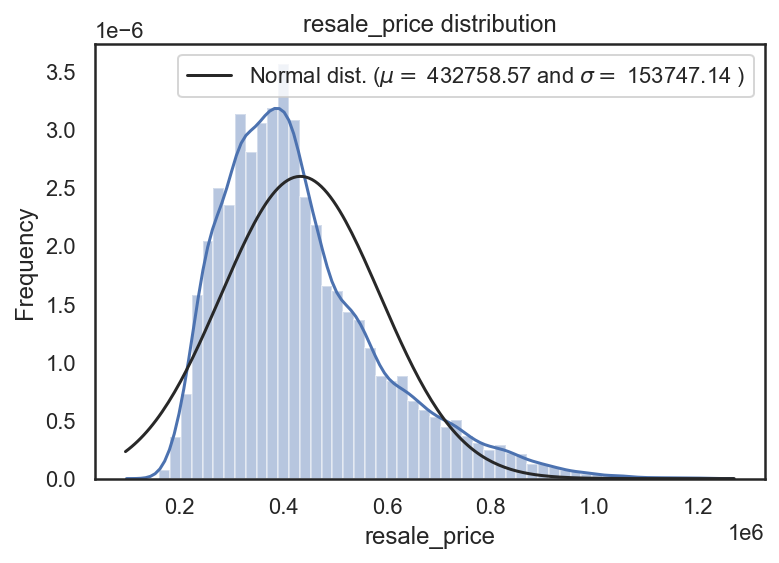

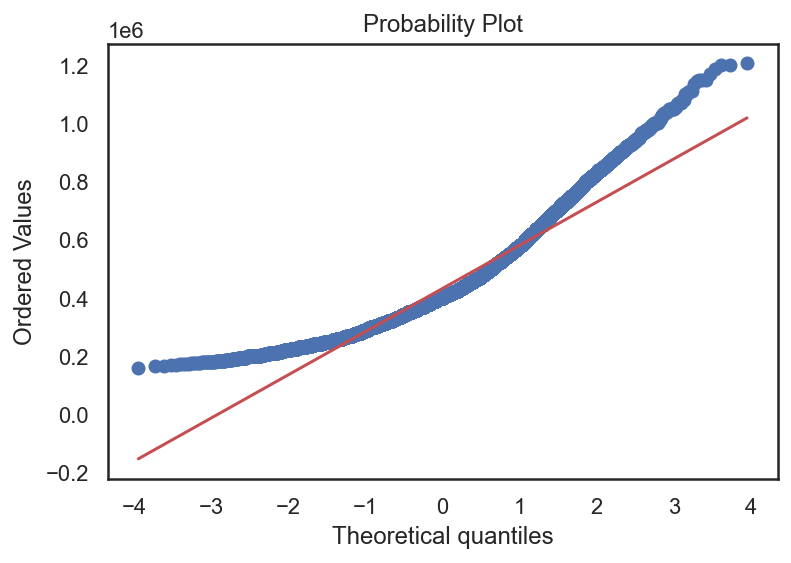

Skewness: 1.097834
Kurtosis: 1.296419


In [12]:
# Plot Histogram
sns.distplot(train['resale_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('resale_price distribution')

fig = plt.figure()
res = stats.probplot(train['resale_price'], plot=plt)
plt.show()

print("Skewness: %f" % train['resale_price'].skew())
print("Kurtosis: %f" % train['resale_price'].kurt())

# 3. Multivariable Analysis

In [13]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['town', 'storey_range', 'flat_type_model'], dtype='object')

In [14]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['floor_area_sqm', 'lease_commence_date', 'remaining_lease',
       'resale_price', 'Month', 'house_age'],
      dtype='object')

In [15]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  3 categorical + 6 numerical = 9 features


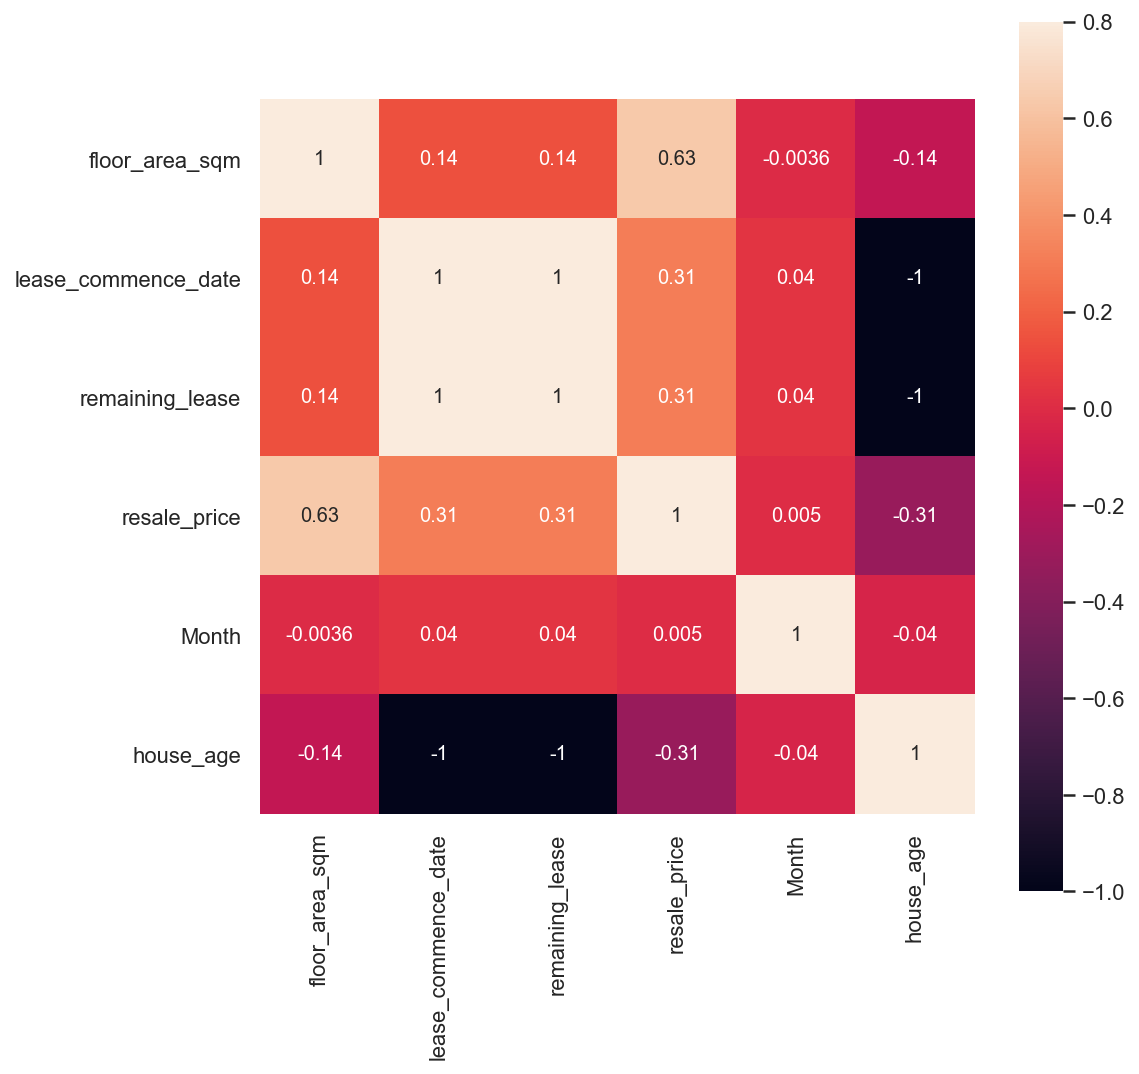

In [16]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, annot = True);

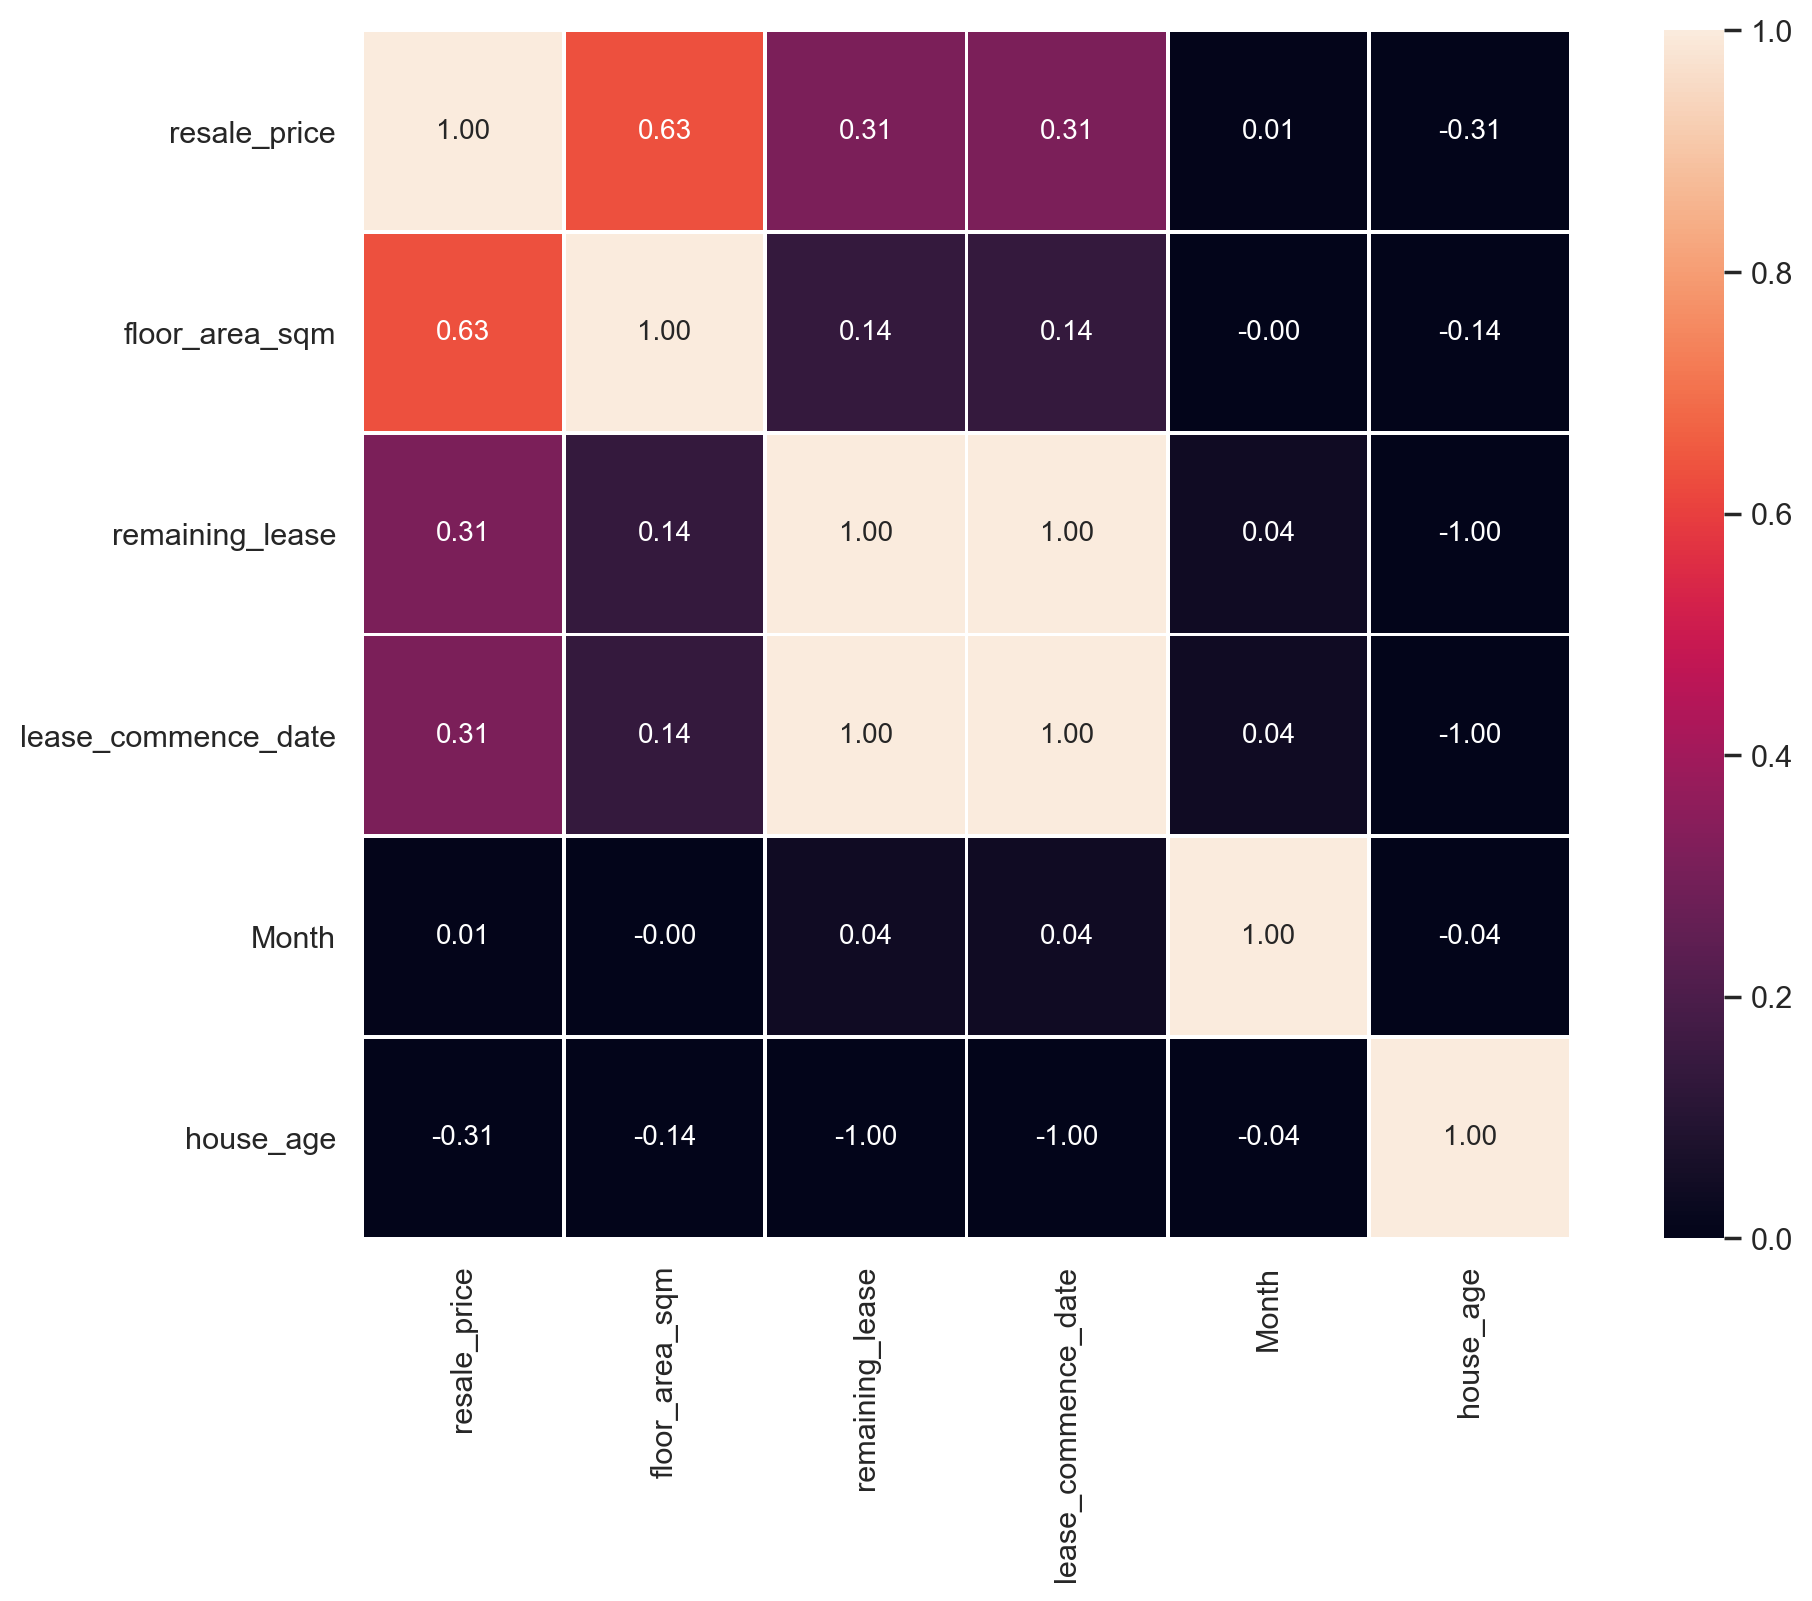

In [17]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'resale_price')['resale_price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(
    context     = 'notebook', 
    style       = 'white',
    palette     = 'deep',
    font        = 'sans-serif',
    font_scale  = 1,
    color_codes = True,
    rc          = {'figure.figsize':(12,8),
                   'figure.dpi': 100}
)
sns.heatmap(cm, vmin=0, vmax=1, cbar=True, annot=True, linewidths= 1, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)



In [18]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,resale_price
1,floor_area_sqm
2,remaining_lease
3,lease_commence_date
4,Month
5,house_age


## Visualisation between resale_price & floor_area_sqm

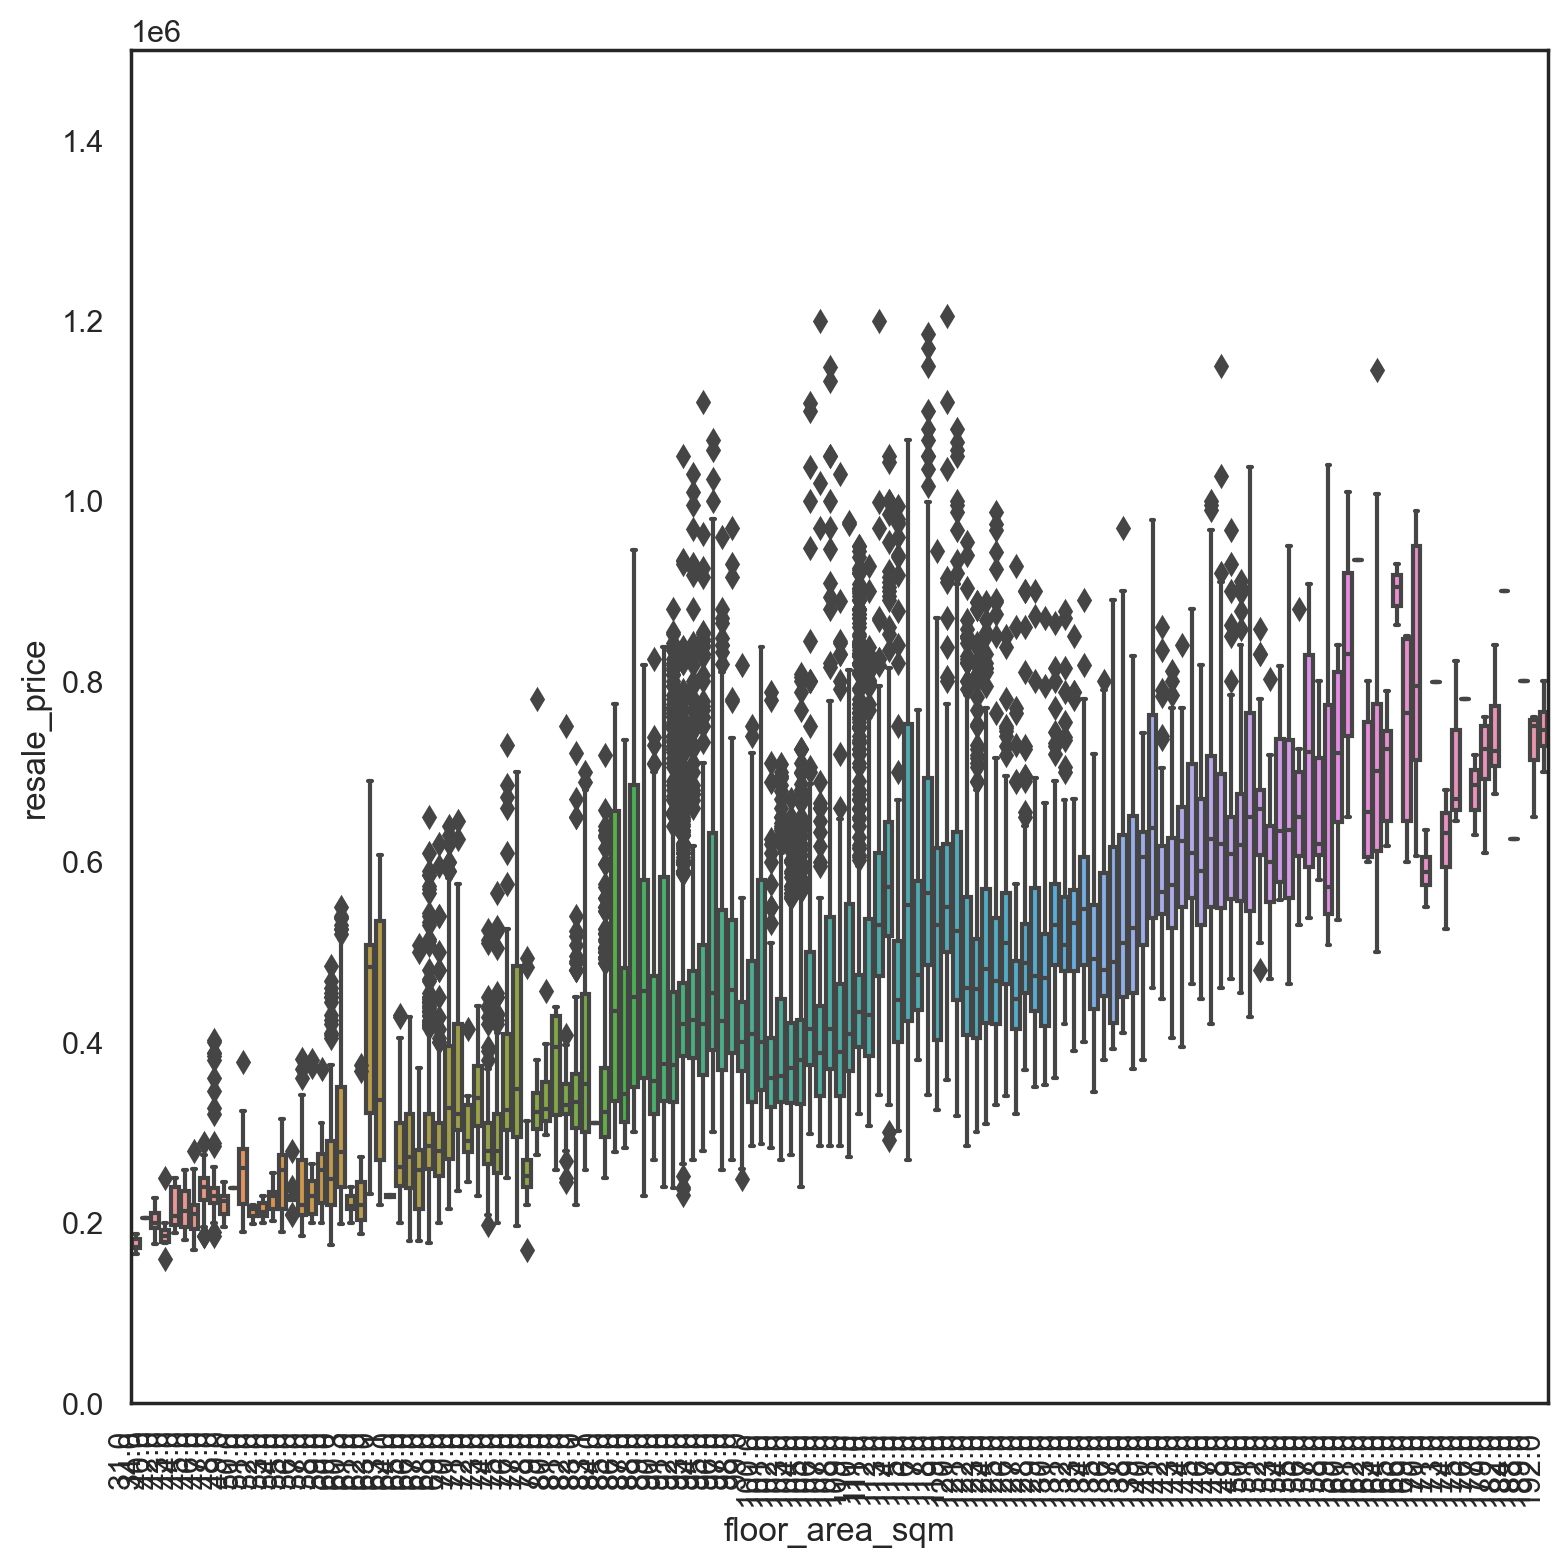

In [19]:
#  floor_area_sqm vs resale_price
var = 'floor_area_sqm'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
# plt.show()

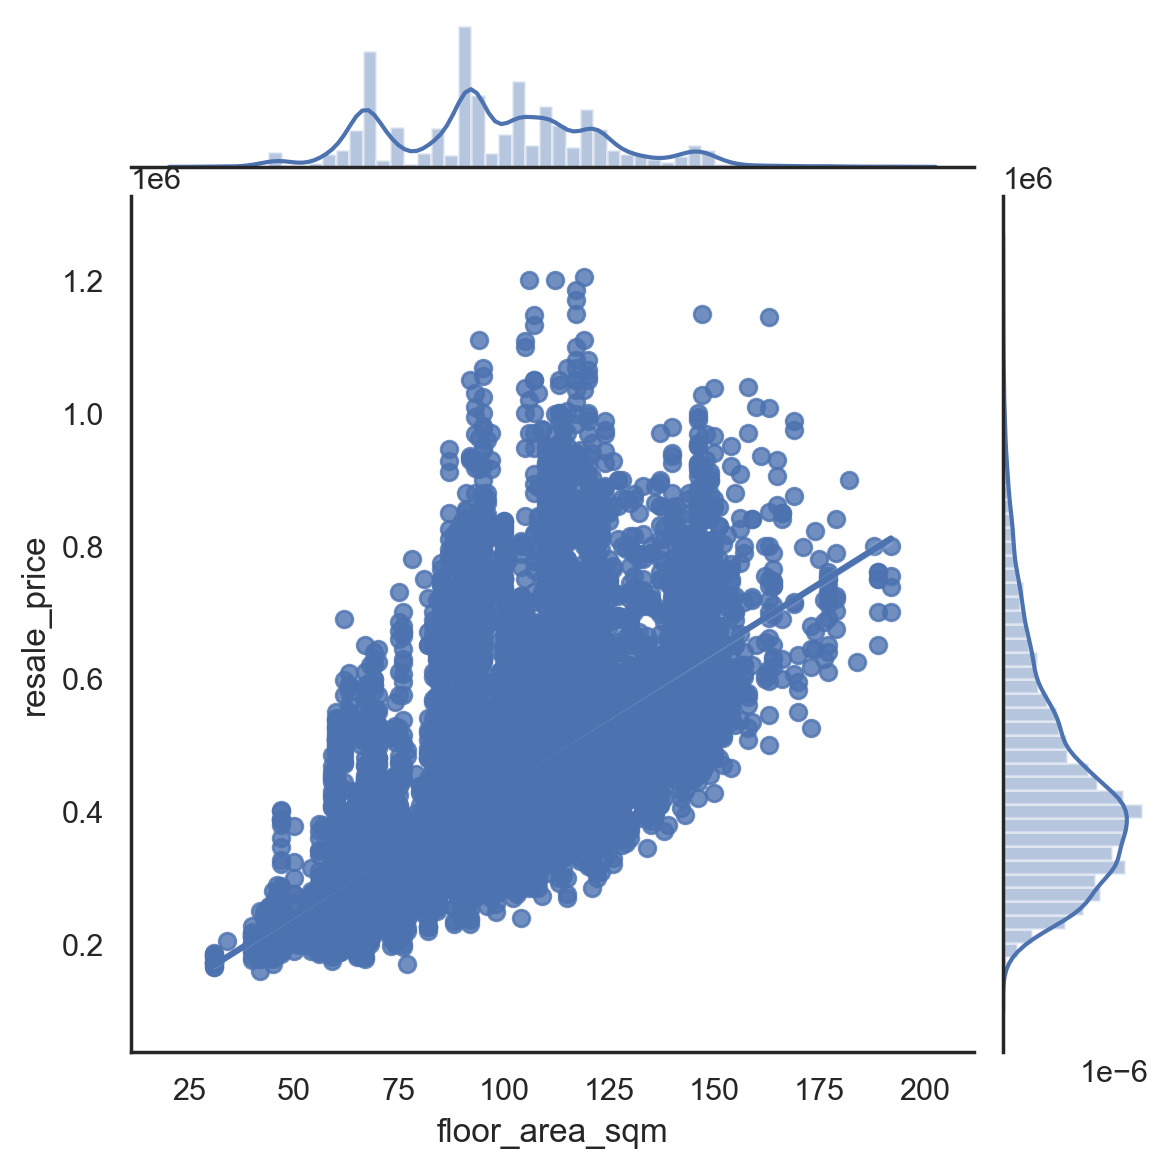

In [20]:
#  floor_area_sqm vs resale_price
sns.jointplot(x=train['floor_area_sqm'], y=train['resale_price'], kind='reg')

## Visualisation between resale_price & lease_commence_date

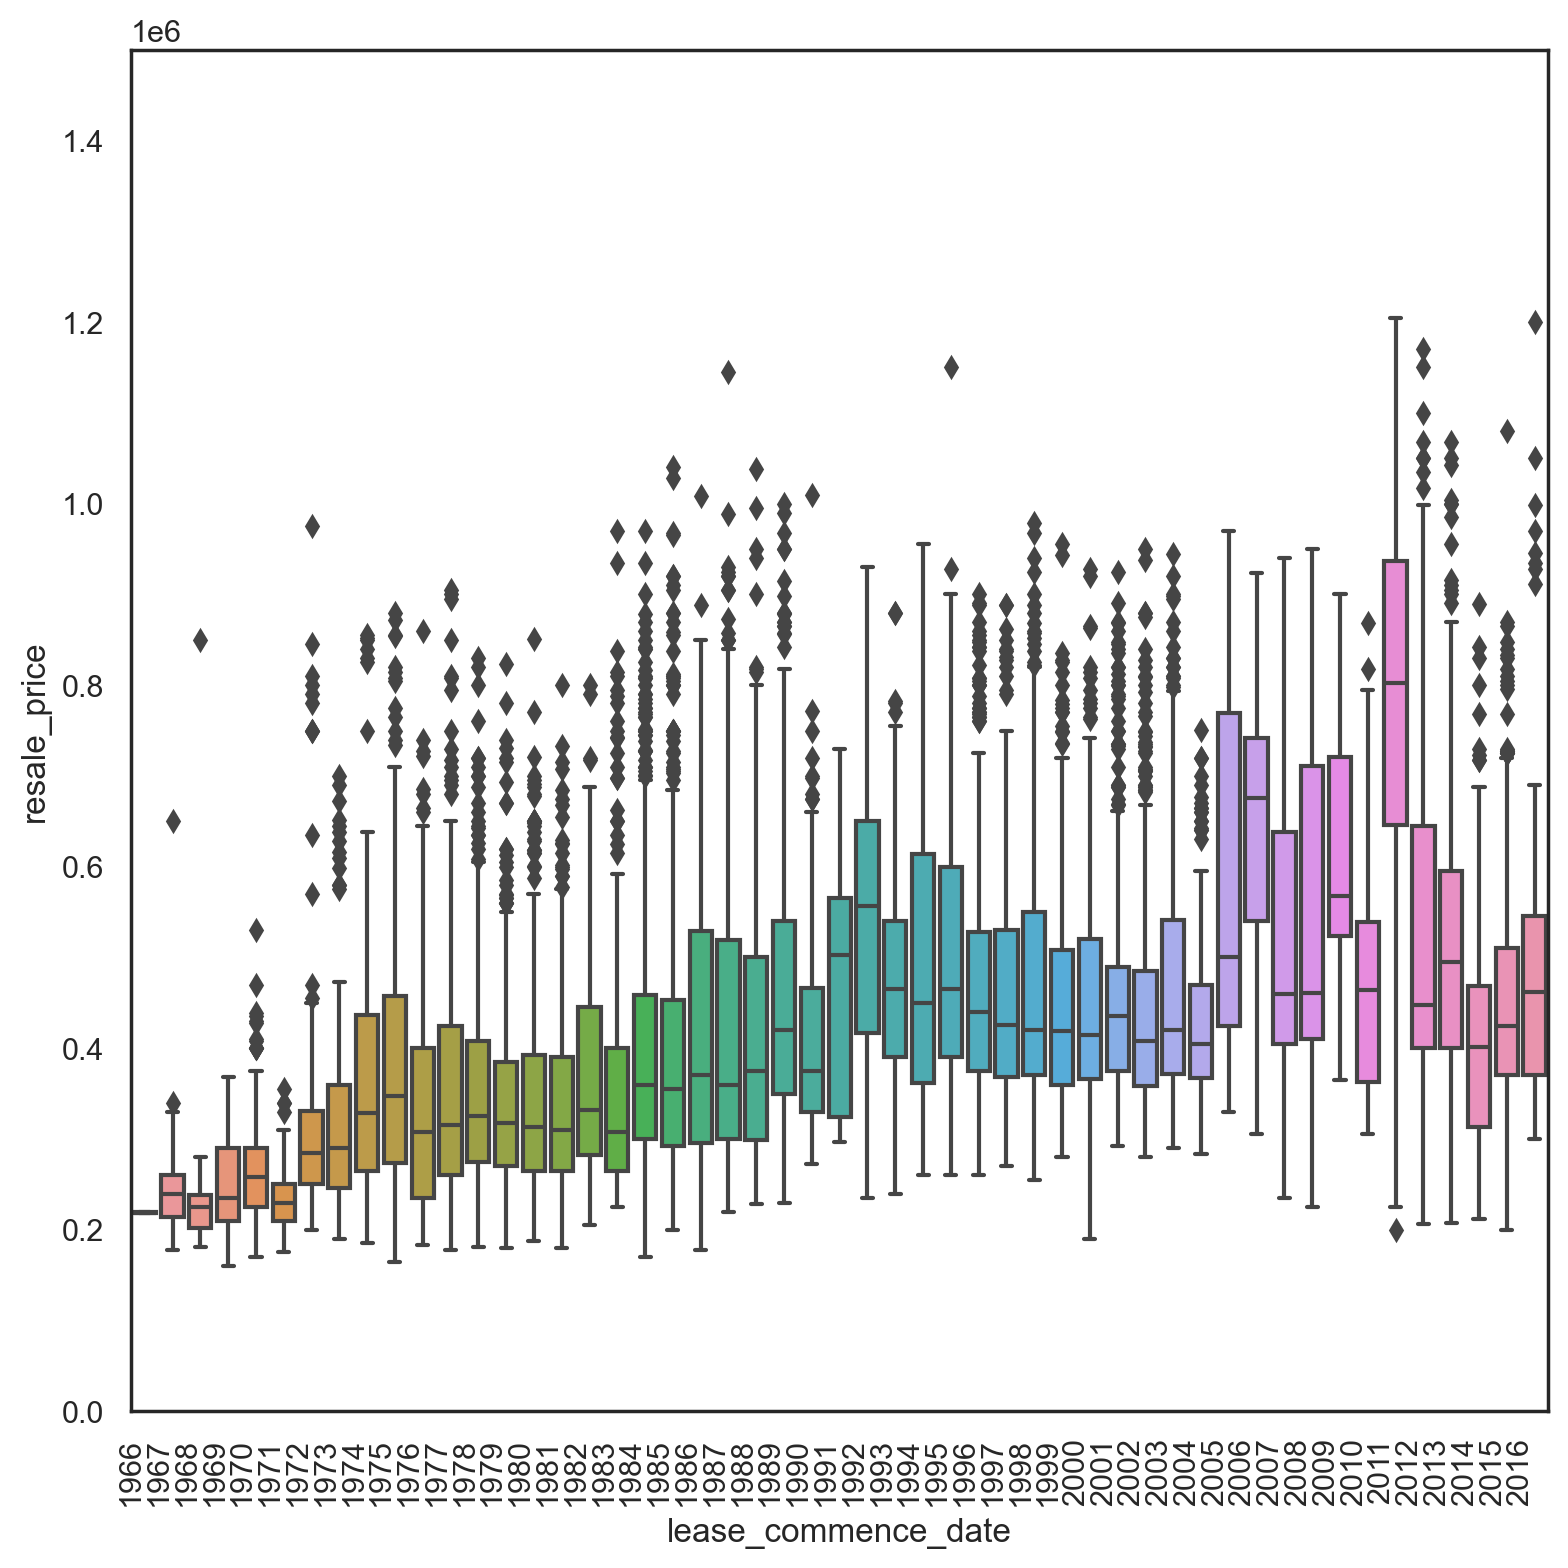

In [21]:
#  lease_commence_date vs resale_price
var = 'lease_commence_date'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
# plt.show()

## Visualisation between resale_price & remaining_lease

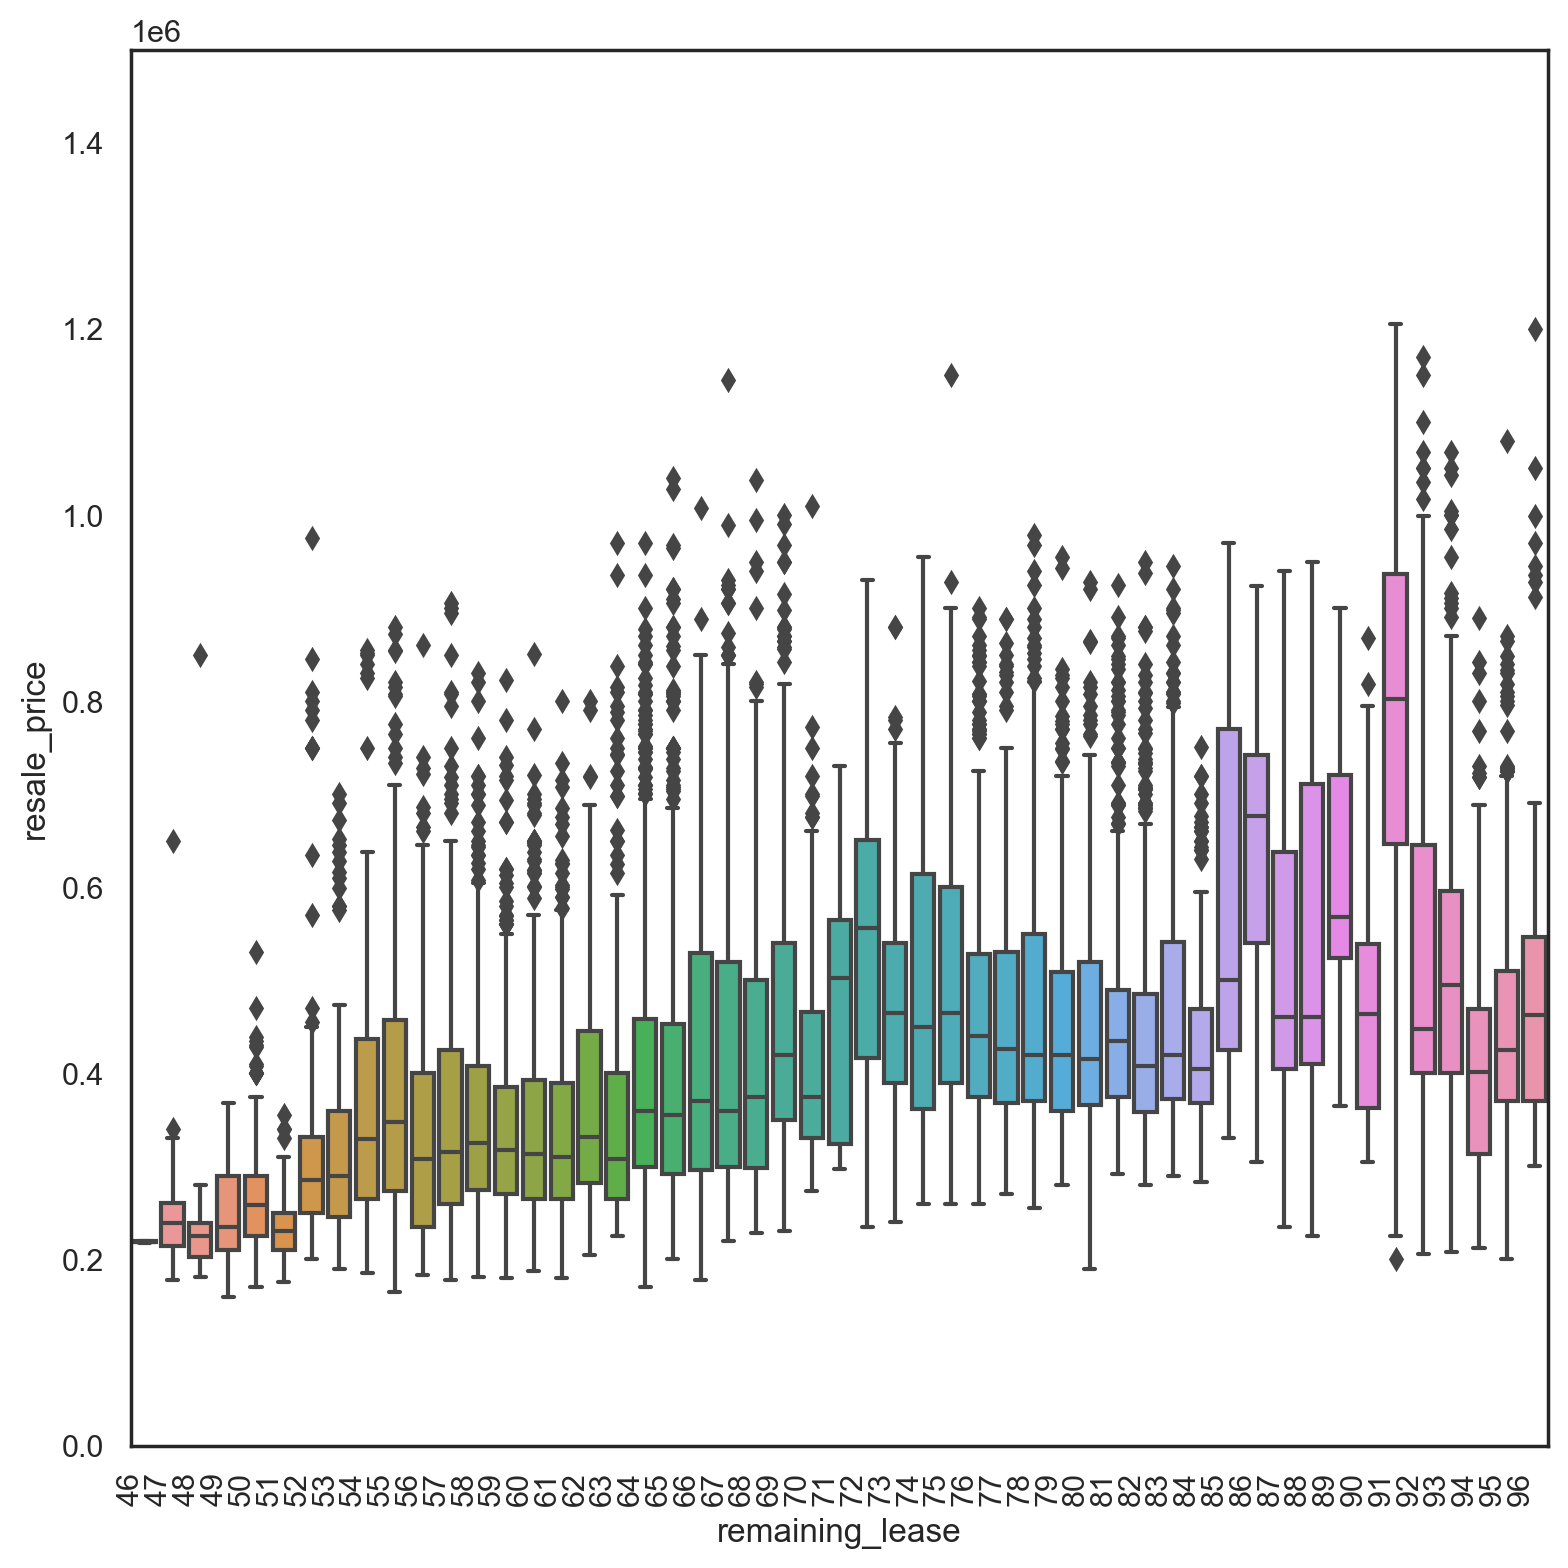

In [22]:
#  remaining_lease vs resale_price
var = 'remaining_lease'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
# plt.show()

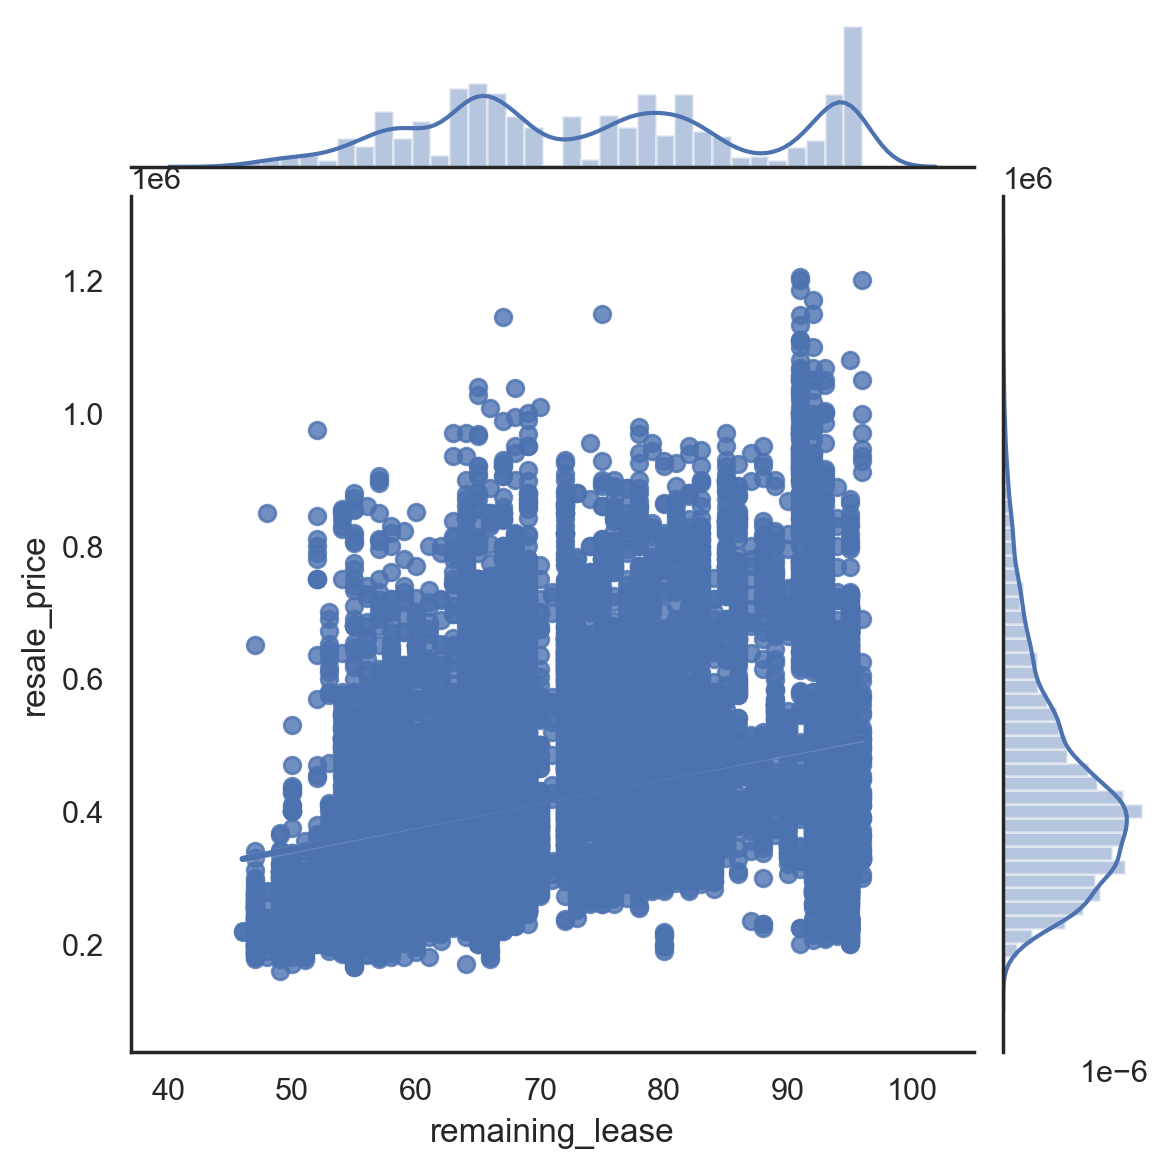

In [23]:
#  remaining_years vs resale_price
sns.jointplot(x=train['remaining_lease'], y=train['resale_price'], kind='reg')

# Impute Missing Data and Clean Data

In [24]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.resale_price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['resale_price'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (17748, 9)
Test data size is : (4438, 9)
Combined dataset size is : (22186, 8)


In [25]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


# Feature Transformation/Engineering


In [26]:
all_data['flat_type_model'].describe()

count              22186
unique                40
top       4 ROOM Model A
freq                5628
Name: flat_type_model, dtype: object

In [27]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22186 entries, 0 to 22185
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   town                 22186 non-null  object 
 1   storey_range         22186 non-null  object 
 2   floor_area_sqm       22186 non-null  float64
 3   lease_commence_date  22186 non-null  int64  
 4   remaining_lease      22186 non-null  int64  
 5   Month                22186 non-null  int64  
 6   house_age            22186 non-null  int64  
 7   flat_type_model      22186 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.4+ MB


In [28]:
# from sklearn.preprocessing import LabelEncoder
# # Process columns and apply LabelEncoder to categorical features
# lbl = LabelEncoder() 
# lbl.fit(list(all_data['storey_range'].values)) 
# all_data['storey_range'] = lbl.transform(list(all_data['storey_range'].values))

# lbl.fit(list(all_data['storey_range'].values)) 
# all_data['storey_range'] = lbl.transform(list(all_data['storey_range'].values))

# # Check shape        
# print('Shape all_data: {}'.format(all_data.shape))

In [29]:
# turn all towns into their respective region, then turn it into nominal values afterwards for easy modelling.

all_data['town'].unique()
all_data['region'] = all_data['town'].map({'ANG MO KIO':'North_East',
                             'BEDOK': 'East',
                             'BISHAN':'Central',
                             'BUKIT BATOK':'West',
                             'BUKIT MERAH':'Central',                 
                             'BUKIT PANJANG':'West',
                             'BUKIT TIMAH':'Central',
                             'CENTRAL AREA':'Central',
                             'CHOA CHU KANG':'West',
                             'CLEMENTI':'West',
                             'GEYLANG':'Central',
                             'HOUGANG':'North_East',
                             'JURONG EAST':'West',
                             'JURONG WEST':'West',
                             'KALLANG/WHAMPOA':'Central',
                             'MARINE PARADE':'Central',
                             'PASIR RIS': 'East',
                             'PUNGGOL':'North_East',
                             'QUEENSTOWN':'Central',
                             'SEMBAWANG': 'North',
                             'SENGKANG':'North_East',
                             'SERANGOON':'North_East',
                             'TAMPINES': 'East',
                             'TOA PAYOH':'Central',
                             'WOODLANDS': 'North',
                             'YISHUN': 'North'})
all_data['region_encoded'] = all_data['region'].map({'West':1,'North':2, 'North_East':3,'East':4,'Central':5})
all_data['storey_range'].unique()
all_data['storey_range'] = all_data['storey_range'].map({
                                        '10 TO 12':1,
                                        '01 TO 03':2,
                                        '04 TO 06':3,
                                        '07 TO 09':4,
                                        '13 TO 15':5,
                                        '19 TO 21':6,
                                        '22 TO 24':7,
                                        '16 TO 18':8,
                                        '34 TO 36':9,
                                        '28 TO 30':10,
                                        '37 TO 39':11,
                                        '49 TO 51':12,
                                        '25 TO 27':13,
                                        '40 TO 42':14,
                                        '31 TO 33':15,
                                        '46 TO 48':16,
                                        '43 TO 45':17})

In [30]:
# remove town and region since we won't need it anymore.
all_data = all_data.drop(columns = ['town','region'])
# all_data.head()


 mu = 12.92 and sigma = 0.34



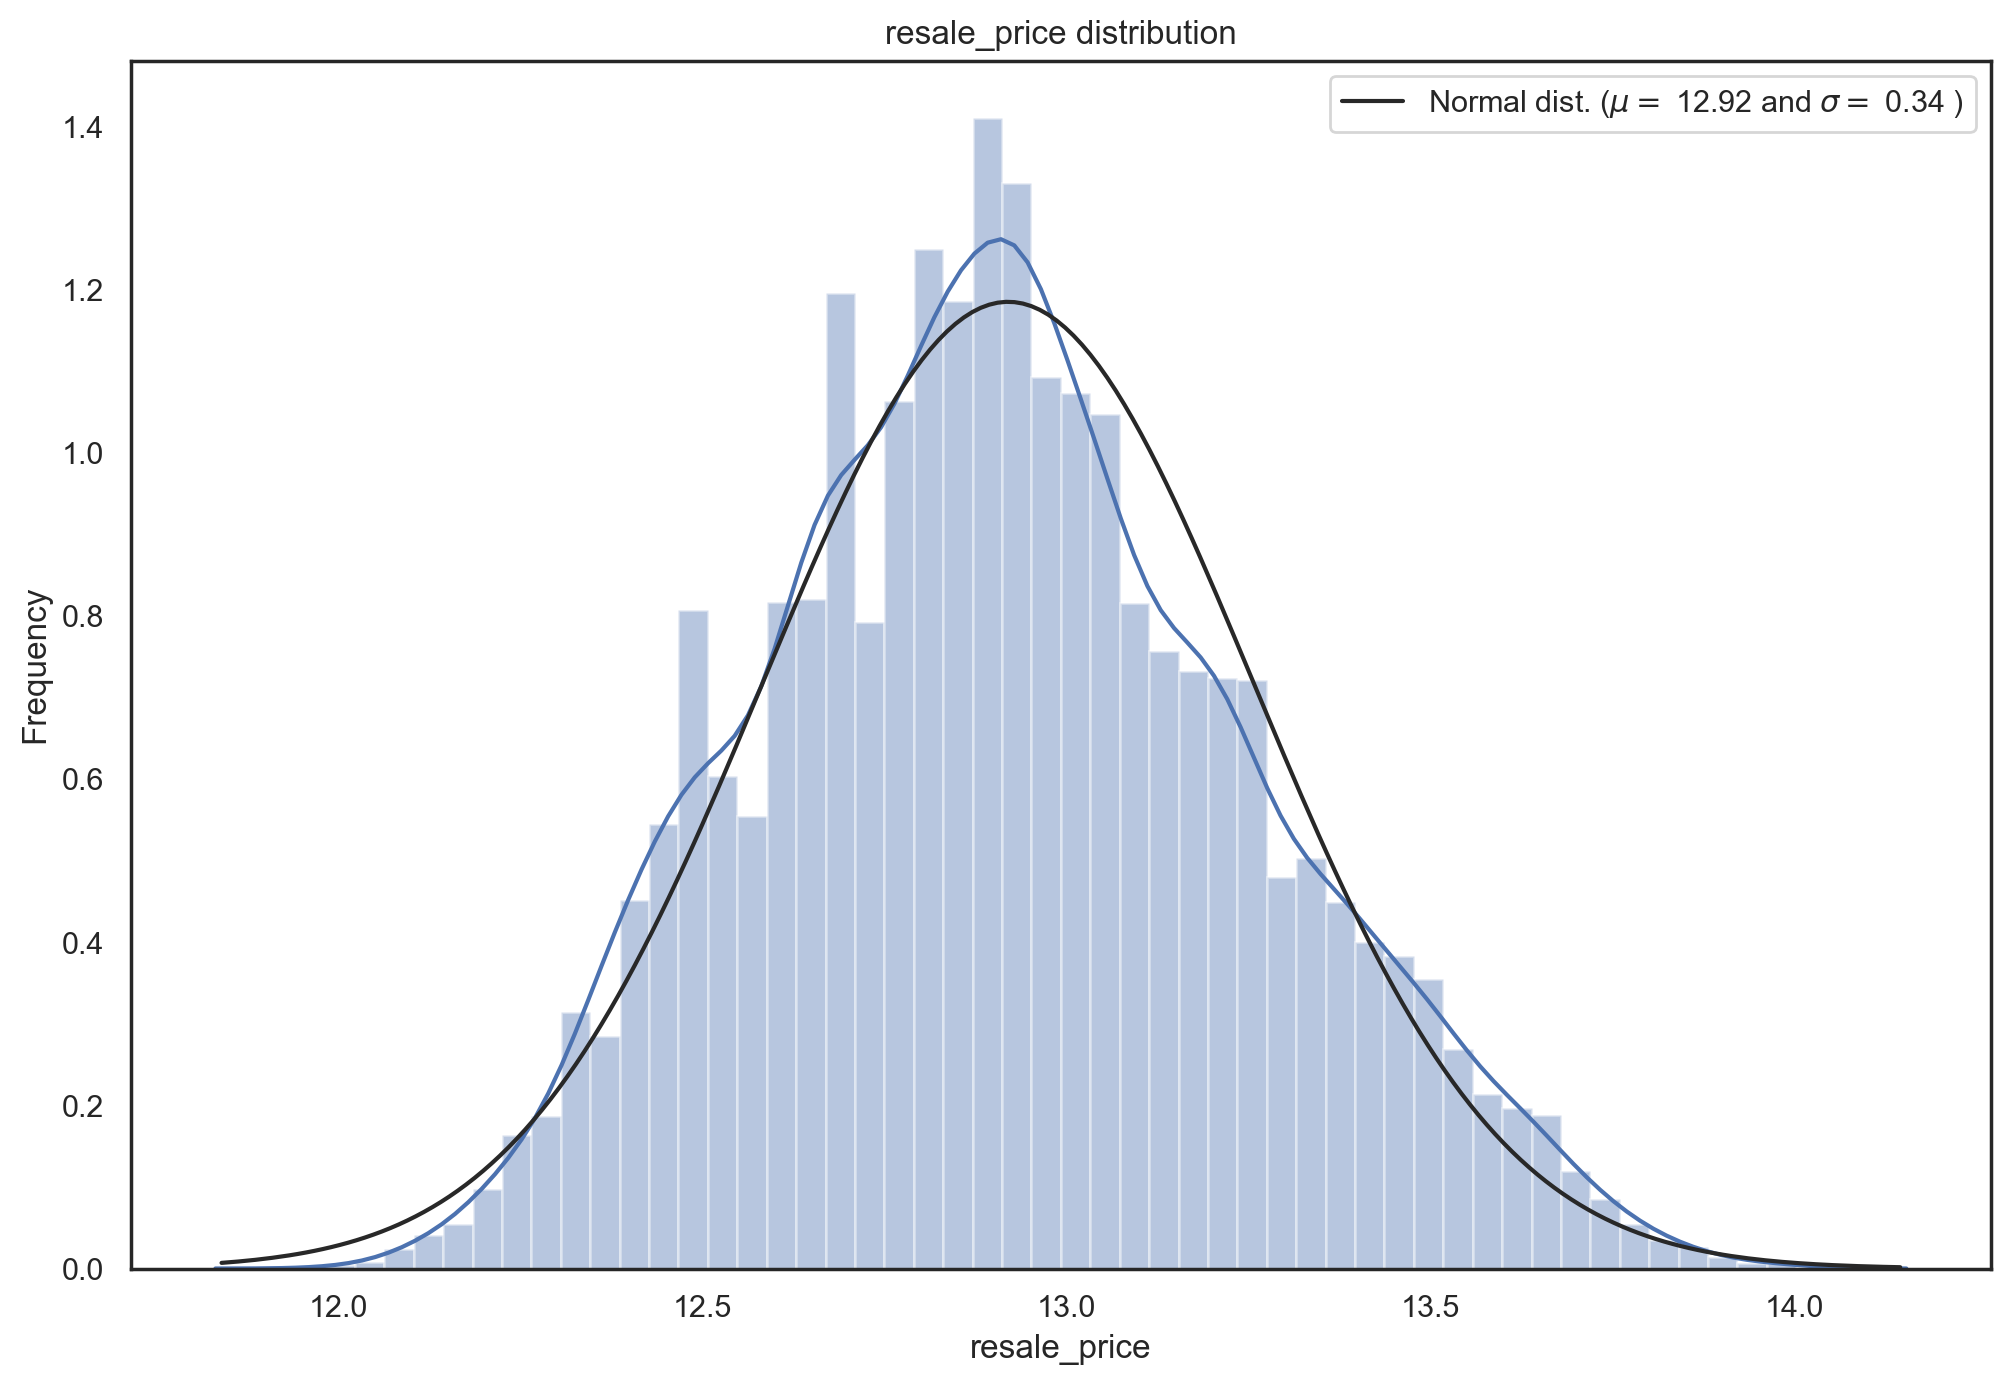

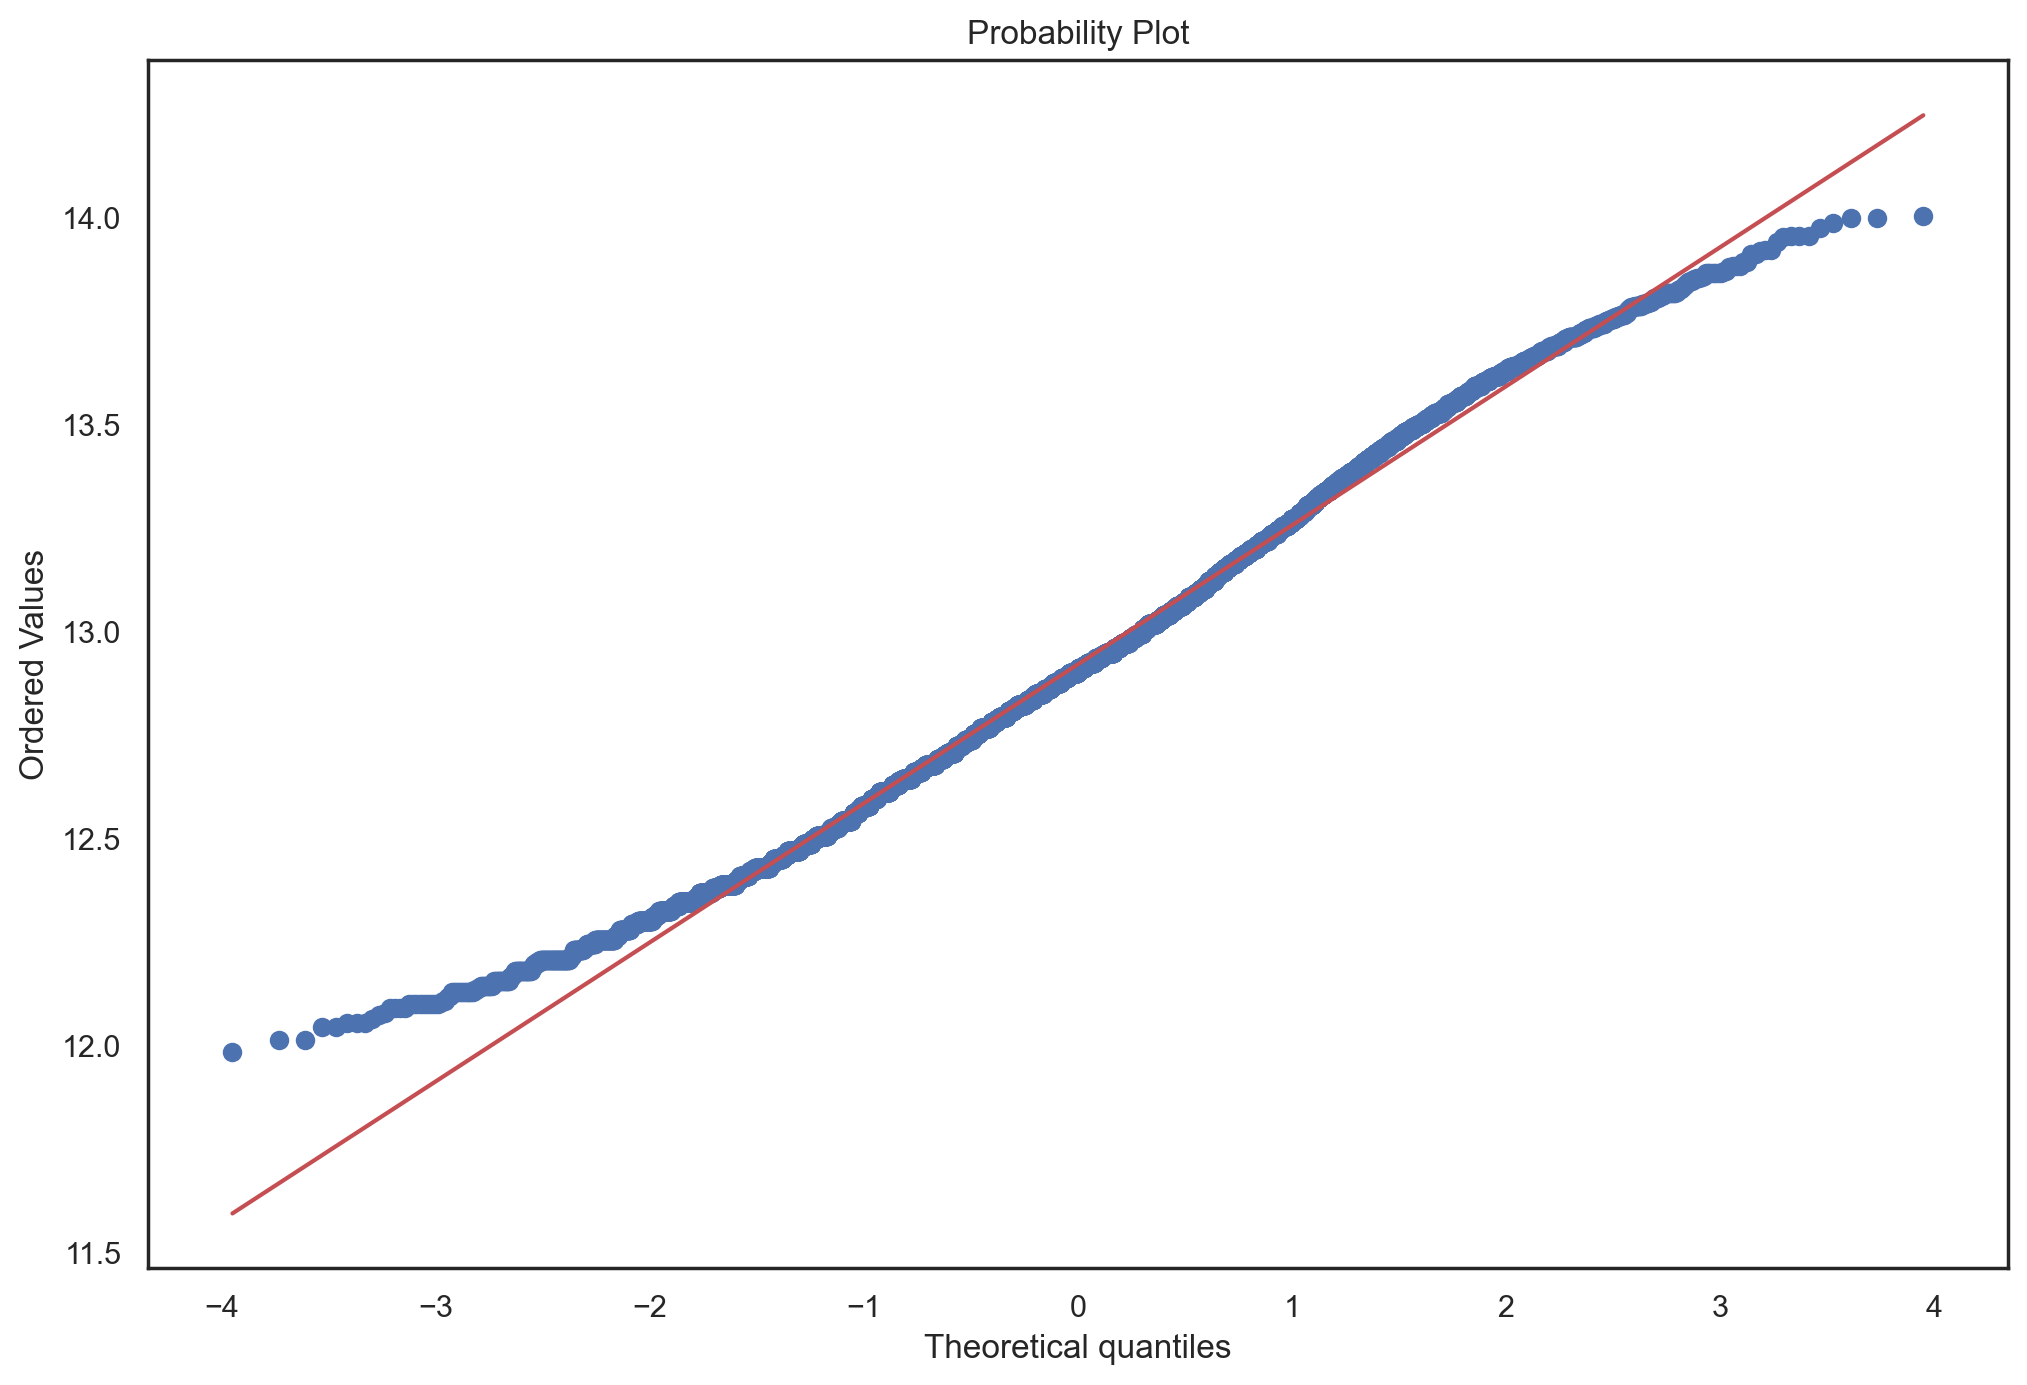

Skewness: 0.223794
Kurtosis: -0.299765


In [31]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements with the resale_price column
train["resale_price"] = np.log1p(train["resale_price"])

#Check the new distribution 
sns.distplot(train['resale_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('resale_price distribution')

fig = plt.figure()
res = stats.probplot(train['resale_price'], plot=plt)
plt.show()

y_train = train.resale_price.values

print("Skewness: %f" % train['resale_price'].skew())
print("Kurtosis: %f" % train['resale_price'].kurt())

In [32]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
storey_range,1.753
floor_area_sqm,0.240
region_encoded,0.174
remaining_lease,0.112
lease_commence_date,0.112


In [33]:
# box cox will take care of right tail skew

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 7 skewed numerical features to Box Cox transform


In [34]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(22186, 47)


In [35]:
# all_data.to_csv('kaggle_2019_only.csv')
all_data

,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,Month,house_age,region_encoded,flat_type_model_1 ROOM Improved,flat_type_model_2 ROOM DBSS,flat_type_model_2 ROOM Improved,...,flat_type_model_5 ROOM Premium Apartment,flat_type_model_5 ROOM Premium Apartment Loft,flat_type_model_5 ROOM Standard,flat_type_model_5 ROOM Type S2,flat_type_model_EXECUTIVE Adjoined flat,flat_type_model_EXECUTIVE Apartment,flat_type_model_EXECUTIVE Maisonette,flat_type_model_EXECUTIVE Premium Apartment,flat_type_model_EXECUTIVE Premium Maisonette,flat_type_model_MULTI-GENERATION Multi Generation
0,2.820,6.831,15.144,6.527,3.260,6.134,3.056,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.541,7.315,15.161,6.860,3.603,5.648,2.541,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.194,7.315,15.166,6.942,3.056,5.492,2.194,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.541,7.733,15.177,7.124,3.260,5.072,2.194,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.056,8.169,15.172,7.048,3.603,5.263,1.730,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22181,2.541,7.048,15.164,6.915,3.440,5.545,2.194,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22182,3.603,8.232,15.183,7.221,4.011,4.782,1.730,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22183,2.820,6.623,15.131,6.248,2.820,6.427,3.056,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22184,2.541,7.073,15.148,6.623,3.440,6.012,2.541,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [37]:
test

,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,Month,house_age,region_encoded,flat_type_model_1 ROOM Improved,flat_type_model_2 ROOM DBSS,flat_type_model_2 ROOM Improved,...,flat_type_model_5 ROOM Premium Apartment,flat_type_model_5 ROOM Premium Apartment Loft,flat_type_model_5 ROOM Standard,flat_type_model_5 ROOM Type S2,flat_type_model_EXECUTIVE Adjoined flat,flat_type_model_EXECUTIVE Apartment,flat_type_model_EXECUTIVE Maisonette,flat_type_model_EXECUTIVE Premium Apartment,flat_type_model_EXECUTIVE Premium Maisonette,flat_type_model_MULTI-GENERATION Multi Generation
17748,2.194,7.845,15.166,6.942,4.128,5.492,2.820,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17749,2.194,7.714,15.159,6.831,3.603,5.697,2.820,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17750,3.056,7.048,15.158,6.803,3.056,5.745,2.820,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17751,1.730,8.483,15.159,6.831,1.730,5.697,2.820,0,0,0,...,0,0,0,0,0,0,1,0,0,0
17752,3.056,6.915,15.208,7.574,4.128,2.541,2.541,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22181,2.541,7.048,15.164,6.915,3.440,5.545,2.194,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22182,3.603,8.232,15.183,7.221,4.011,4.782,1.730,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22183,2.820,6.623,15.131,6.248,2.820,6.427,3.056,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22184,2.541,7.073,15.148,6.623,3.440,6.012,2.541,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Predicions and Modelling

In [38]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Functions for: RMSLE & R2

In [39]:
# Cross-validation with k-folds
#5 Fold is for the sake of processing speed (cpu limitations)
n_folds = 5 

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def r2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    r2 = cross_val_score(model, train.values, y_train, scoring='r2', cv = kf)
    return(r2)

In [40]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### RMSLE cv Models

In [41]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1710 (0.0022)

ElasticNet score: 0.1708 (0.0021)

Kernel Ridge score: 0.1493 (0.0015)

Gradient Boosting score: 0.1062 (0.0013)

[18:41:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:42:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:42:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\le

# R2 for cv models

In [42]:
score = r2_cv(lasso)
print("\nLasso r2 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = r2_cv(ENet)
print("ElasticNet r2 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = r2_cv(KRR)
print("Kernel Ridge r2 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = r2_cv(GBoost)
print("Gradient Boosting r2 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = r2_cv(model_xgb)
print("Xgboost r2 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = r2_cv(model_lgb)
print("LGBM r2 score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))



Lasso r2 score: 0.7417 (0.0065)

ElasticNet r2 score: 0.7424 (0.0064)

Kernel Ridge r2 score: 0.8032 (0.0037)

Gradient Boosting r2 score: 0.9003 (0.0022)

[18:48:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_

## Averaging model

In [43]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

### RMSLE averaging model

In [44]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, model_xgb, model_lgb))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[18:53:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[18

### R2 averaging model

In [45]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, model_xgb, model_lgb))

score = r2_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[19:00:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[19

# Stacking Average Model
- Stacking to hopefully improve rmsle and r2 to improve prediction

In [46]:
# Stacking is a technique that can give even better results, by implementing a meta-model that is xgb (xgb yielded best result) 
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

## RMSLE Stacking Average Model

In [47]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, lasso, model_xgb, model_lgb),
                                                 meta_model = model_xgb)
#xgboost has the best score, thus it is used as the meta model
stack = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[19:10:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:10:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:11:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[19:30:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:31:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:31:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

## R2 Stacking Average Model

In [48]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, lasso, model_xgb, model_lgb),
                                                 meta_model = model_xgb)

#xgboost has the best score, thus it is used as the meta model
stack_r2 = r2_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[19:42:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:43:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:43:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

KeyboardInterrupt: 

# RMSE training data

In [ ]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
stack = rmse(y_train, stacked_train_pred)
print(rmse(y_train, stacked_train_pred))

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmse(y_train, xgb_train_pred))

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmse(y_train, lgb_train_pred))

In [ ]:
print('RMSE score on train data:')
print(rmse(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgb_train_pred*0.20 ))

# the lower rmsle score, the more weightage it holds. Which in this case, stacked: 1st, Xgb: 2nd, lgb: 3rd

# Ensemble Prediction

In [ ]:
# the value for below is taken from above.
Stacked = 1/(0.09990378611862295)
XGBoost = 1/(0.1039  )
LGBM = 1/(0.1171 )
Sum = Stacked + XGBoost + LGBM
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
LGBM1 = LGBM/Sum
print(Stacked, XGBoost, LGBM)

### RMSLE Ensemble

In [ ]:
print('RMSLE score on train data:')
print(rmse(y_train,stacked_train_pred*Stacked1 +
               xgb_train_pred*XGBoost1 + lgb_train_pred*LGBM1))

## Ensemble resale_price Prediction

In [ ]:
ensemble = stacked_pred*Stacked1 + xgb_pred*XGBoost1 + lgb_pred*LGBM1
ensemble

In [ ]:
ensemble

In [ ]:
test

In [ ]:
sub_en = pd.DataFrame()
sub_en = x_test
# sub['Id'] = test_ID
sub_en['predicted_resale_Price'] = ensemble
sub_en['Assigned_resale_price']=x_test['resale_price']
sub_en['Predicted_Assigned_%_Diff'] = (abs(sub_en['Assigned_resale_price']-sub_en['predicted_resale_Price'])/sub_en['Assigned_resale_price'])*100
sub_en.head(5)

### R2 Ensemble

In [ ]:
from sklearn.metrics import r2_score

print('R2 score for ensemble:')
print(r2_score(sub_en['resale_price'], sub_en['predicted_resale_Price']))

In [ ]:
sub_en['Predicted_Assigned_%_Diff'].describe()

In [ ]:
# below is for xgboost only
XGB = xgb_pred

sub_xgb = pd.DataFrame()
sub_xgb = x_test
# sub['Id'] = test_ID
sub_xgb['predicted_resale_Price'] = XGB
sub_xgb['Assigned_resale_price']=x_test['resale_price']
sub_xgb['Predicted_Assigned_%_Diff'] = (abs(sub_xgb['Assigned_resale_price']-sub_xgb['predicted_resale_Price'])/sub_xgb['Assigned_resale_price'])*100
sub_xgb.head(5)

## R2 xgboost

In [ ]:
from sklearn.metrics import r2_score

print('R2 score for xgboost:')
print(r2_score(sub_xgb['resale_price'], sub_xgb['predicted_resale_Price']))

In [ ]:
# Xgboost
sub_xgb['Predicted_Assigned_%_Diff'].describe()

## Conclusion:
1. Xgboost scored the highest individually.
1. Xgboost(0.89819) has a higher R2 compared to ensemble(0.88502) 